# Tutorial 8.2: Competition via STDP
### Neuroscience goals:
- understand STDP in action
- discover how responses can become selective either by spontaneous activity breaking or selection of correlated inputs
### Computational goals:
- practice defining and manipulating distinct subsets of an array differently
- practice updating variables appropriately within a nested loop

### Overview
- will see STDP can produce a selective response in a neuron by preferentially strengthening one subset of its incoming synapses while weakinging all other inputs

## 1. generation of input spike trains and synaptic conductance
### a. 
- define 50 input spike trains, grouped into two subsets (a, b) of 25
- each subset follows a single time-varying rate ($r_a or r_b$) given by:

$$
r_{a,b}(t) = \frac{r_{max}}{2} [1+\sin(2\pi vt + \phi_{a,b})]
$$

with maximum rate of r_max = 60, frequency of osciallation of v = 20, and phase offsets of $\phi_a$ = 0 and $\phi_b$ = $\pi$

In [383]:
import numpy as np
import matplotlib.pyplot as plt

In [384]:
# parameters
r_max = 60
v = 20
phi_a = 0
phi_b = np.pi


In [385]:
tmax = 0.5
dt = 0.1e-3
t = np.arange(0, tmax, dt)

## b.
- produce an array of input spikes, with 50 rows and a number of columns equal to the number of timesteps per trial (trial = 0.5s, dt = 0.1ms)
- produce spikes according to an inhomogenous (time-varying) Poisson process with rate $r_a(t)$ for rows 1-25, and rate $r_b(t)$ for rows 26-50
- each row represents a single trial of inputs

In [386]:
# functions
def rate(t, phi):
    return (r_max // 2) * (1 + np.sin(2*np.pi * v * t + phi))

def generate_spike_train(phi, num_trials):
    spike_train = np.zeros((num_trials, len(t)))
    for trial in range(num_trials):
        for timestep in range(len(t)):
            t_val = timestep * dt
            if np.random.rand() < rate(t_val, phi) * dt:
                spike_train[trial][timestep] = 1
    return spike_train

spike_train_a = generate_spike_train(phi_a, 25)
spike_train_b = generate_spike_train(phi_b, 25)

input_spikes = np.vstack((spike_train_a, spike_train_b))

### c.
- produce a vector of initial values of the synaptic strength, $G_i$, of each input synapse, labeled $i$ (one per distinct incoming spike train) with all entries sampled from a normal distribution with mean 500 pS and standard deviation 25 pS

In [387]:
g_i = np.random.normal(500e-12, 25e-12, 50)

### d.
- produce a single vector representing the total (summed) synaptic excitatory conductance, $G_{syn}(t)$
- increment $G_{syn}(t)$ by an amount, $G_i$, at the time of each incoming spike at each input synapse, $i$
- between spikes, $G_{syn}(t)$ decays exponentially to zero, with a time constant $\tau_{syn}$ = 2ms

In [388]:
tau_syn = 2e-3

def get_synaptic_conductance(input_spikes, g_i):
    g_syn = np.zeros_like(t)

    for timestep in range(1, len(t)):
        # exponential decay
        g_syn[timestep] = g_syn[timestep - 1] * np.exp(-dt / tau_syn)
        
        # add synaptic strength for each spike
        for i in range(len(g_i)):
            if input_spikes[i][timestep] == 1:
                g_syn[timestep] += g_i[i]
    return g_syn


## 2. simulate spike train of LIF neuron receiving these inputs
### a. 
- simulate membrane potential of LIF neuron that follows:

$$
C_m\frac{dV}{dt} = G_L(E_L - V)+G_{syn}(E_{syn} - V)
$$

where if V > V_th then V -> V_reset

with parameters:
c_m = 100pF
g_l = 5nS
e_l = -70mV
e_syn = 0mV
v_th = -50mV
v_reset = -80V

initialized with V(0) = e_l

In [394]:
# LIF parameters
c_membrane = 100e-12
g_leak = 5e-9
e_leak = -70e-3
e_syn = 0
v_thresh = -50e-3
v_reset = -80e-3
v_peak = 40e-3

In [395]:
# LIF function

def update_v(v, g_syn):
    dvdt = (g_leak * (e_leak - v) + g_syn * (e_syn - v)) / c_membrane
    return dvdt

def run_lif(g_syn):
    # initialize membrane potential array
    v = np.zeros_like(t)
    v[0] = e_leak

    # through time
    for i in range(1, len(t)):
        dvdt = update_v(v[i - 1], g_syn[i - 1])
        v[i] = v[i - 1] + dvdt*dt

        # if spike
        if v[i] >= v_thresh:
            v[i] = v_reset
            v[i - 1] = v_peak
    
    return v

### b.
- record all the spike times of the LIF neuron produced during the trial

### c. 
- plot the total synaptic conductance and membrane potential as a function of time

In [403]:
g_syn = get_synaptic_conductance(input_spikes, g_i)
vm = run_lif(g_syn)
spike_times = np.where(vm == v_peak)

Text(0.5, 1.0, 'membrane potential and synaptic conductance over time')

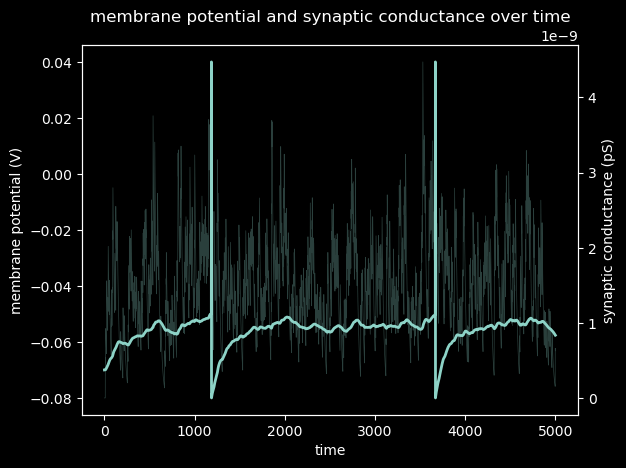

In [410]:
fig, ax1 = plt.subplots()

# membrane potential
ax1.plot(vm, linewidth=2)
ax1.set_xlabel('time')
ax1.set_ylabel('membrane potential (V)')
ax1.tick_params('y')

# synaptic conductance
ax2 = ax1.twinx()
ax2.plot(g_syn, alpha=0.3, linewidth=0.5)
ax2.set_ylabel('synaptic conductance (pS)')

plt.title('membrane potential and synaptic conductance over time')

## 3. update input synaptic strengths using STDP rule after the trial using batch method
### a.
- for each input neuron and each input spike compare the time, $t_{pre}$, of the input (presynaptic) spike to the time, $t_{post}$ of each spike of the LIF neuron (postsynaptic)
- change the synaptic strength, $G_{i}$ of that input connection according to the rule:

$$
G_i\rightarrow G_i + \Delta G_{LTP}\exp(\frac{t_{pre} - t_{post}}{\tau_{LTP}}) \space\space\text{if} t_{pre} \lt t_{post}
$$

or

$$
G_i\rightarrow G_i + \Delta G_{LTD}\exp(\frac{t_{post} - t_{pre}}{\tau_{LTD}}) \space\space\text{if} t_{pre} \gt t_{post}
$$

with $\Delta G_{LTP} = 20\text{pS}, \Delta G_{LTD} = 25\text{pS}, \space\text{and} \tau_{LTP} = \tau_{LTD} = 20\text{ms}$

### b. 
- ensure synaptic strengths are neither less than zero nor grater than $G^{max} = 2\text{nS}$

### c. 
- record the mean synaptic strength for each set of 25 inputs and plot the set of synaptic strengths as a function of input number

### d.
- explain how the synaptic strengths change across trials and how the changing synaptic strengths impact the time variation of the input conductance and the pattern of the LIF neuron's spike train. repeat the simulation and explain any differences